In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.metrics import mean_squared_error, r2_score

In [58]:
file_path = '/content/drive/MyDrive/BengaluruHousePrice_Prediction.csv'
df = pd.read_csv(file_path)
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [59]:
df.shape

(13320, 9)

In [60]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [61]:
df['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [62]:
df['area_type'].value_counts()

,count
area_type,
Super built-up Area,8790
Built-up Area,2418
Plot Area,2025
Carpet Area,87


**Droping features that are less impactful**

In [63]:
df2 = df.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

**Handelling null values**

In [64]:
df2.isnull().sum()

,0
location,1
size,16
total_sqft,0
bath,73
price,0


In [65]:
df3 = df2.dropna()
df3.isnull().sum()

,0
location,0
size,0
total_sqft,0
bath,0
price,0


In [66]:
df3.shape

(13246, 5)

In [67]:
df3['bhk'] = df3['size'].apply(lambda x : x.split(' ')[0])
df3['bhk'].unique()

<ipython-input-67-05c782e66e85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x : x.split(' ')[0])


array(['2', '4', '3', '6', '1', '8', '7', '5', '11', '9', '27', '10',
       '19', '16', '43', '14', '12', '13', '18'], dtype=object)

In [68]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [69]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [70]:
# Converting the price range to its average of min and max , and dropping others
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [71]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


**Feature Engineering**

In [72]:
#Adding a new feature named price_per_sqfit
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [73]:
df5.to_csv("bhp_copy.csv",index=False)

In [74]:
#Examining categorical variables and applying dimensionality reduction if necessary
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

,count
location,
Whitefield,533
Sarjapur Road,392
Electronic City,304
Kanakpura Road,264
Thanisandra,235
...,...
Zuzuvadi,1
Chellikere,1
Jakkasandra,1


In [75]:
location_stats.values.sum()

np.int64(13200)

In [76]:
len(location_stats[location_stats>10])

240

In [77]:
len(location_stats)

1287

In [78]:
len(location_stats[location_stats<=10])

1047

**Dimensionality Reduction**

In [79]:
#checking how many data locations have less than 10 data points
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

,count
location,
Ganga Nagar,10
Kalkere,10
Dairy Circle,10
1st Block Koramangala,10
Sector 1 HSR Layout,10
...,...
Zuzuvadi,1
Chellikere,1
Jakkasandra,1


In [80]:
#Tagging locations as 'others' which has less than 10 data points
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [81]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


**Outlier Removal**

 Assuming a normally sqft per bedroom is around 300 i.e a 2bhk appartment's bedroom would be around 600 sqft.If a person is having a 2bhk appartment with 400 sqft , that seems suspisious and can be removed as outlier. We will remove outliers by having threshold to 300

In [82]:
df5['bhk'] = df5['bhk'].astype('int')

In [83]:
df5.dtypes

,0
location,object
size,object
total_sqft,float64
bath,float64
price,float64
bhk,int64
price_per_sqft,float64


In [84]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [85]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

In [86]:
df6.price_per_sqft.describe()

,price_per_sqft
count,12456.000000
mean,6308.502826
std,4168.127339
min,267.829813
25%,4210.526316
50%,5294.117647
75%,6916.666667
max,176470.588235


In [87]:
def remove_pps_outliers(df):

  """
  Removes outliers in the 'price_per_sqft' column for each location in the dataset.

  This function groups the DataFrame by 'location' and filters out outliers
  based on the standard deviation method. Any value outside the range
  (mean - std) to (mean + std) for 'price_per_sqft' within each location is removed.

  Parameters:
  -----------
  df : pd.DataFrame
      The input DataFrame containing a 'location' column and a 'price_per_sqft' column.

  Returns:
  --------
  pd.DataFrame
      A DataFrame with outliers removed based on the standard deviation threshold
      within each location.

  Example:
  --------
  >>> df_filtered = remove_pps_outliers(df)
  >>> df_filtered.shape

  """

  def filter_outliers(subdf):

    m = subdf.price_per_sqft.mean()
    st = subdf.price_per_sqft.std()
    return subdf[(subdf.price_per_sqft > (m - st)) & (subdf.price_per_sqft <= (m + st))]

  return df.groupby('location', group_keys=False).apply(filter_outliers)

df7 = remove_pps_outliers(df6)
df7.shape

<ipython-input-87-0fdda61c4a47>:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('location', group_keys=False).apply(filter_outliers)


(10293, 7)

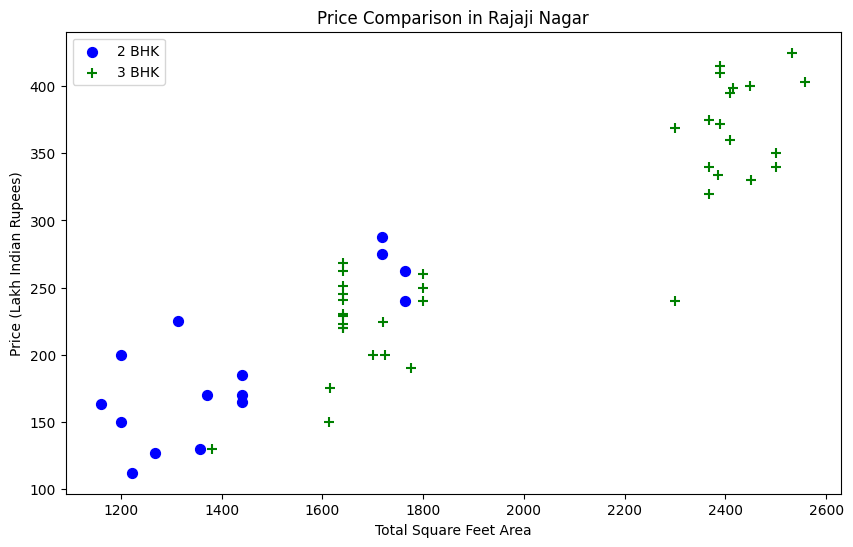

In [88]:
def plot_scatter_chart(df, location):
    """Plots a scatter chart comparing 2 BHK and 3 BHK prices for a given location."""
    df_location = df[df.location == location]

    bhk2 = df_location[df_location.bhk == 2]
    bhk3 = df_location[df_location.bhk == 3]

    plt.figure(figsize=(10, 6))
    plt.scatter(bhk2.total_sqft, bhk2.price, color='blue', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+', color='green', label='3 BHK', s=50)

    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(f"Price Comparison in {location}")
    plt.legend()
    plt.show()

plot_scatter_chart(df7, "Rajaji Nagar")


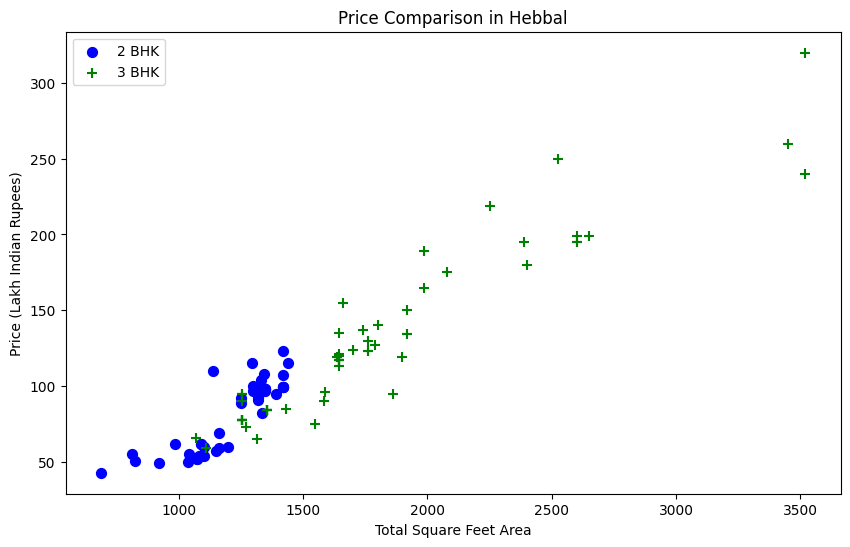

In [89]:
plot_scatter_chart(df7,"Hebbal")

 Removing the data points where lower bhk appartments have higher price than the highr price ones for same location.

In [90]:
def filter_bhk_outliers(df):
    """Removes BHK outliers where a higher BHK has a lower price per square foot than the lower BHK."""
    indices_to_remove = np.array([])

    for location, loc_df in df.groupby('location'):
        bhk_stats = {
            bhk: {
                'mean': bhk_df.price_per_sqft.mean(),
                'std': bhk_df.price_per_sqft.std(),
                'count': len(bhk_df)
            }
            for bhk, bhk_df in loc_df.groupby('bhk')
        }

        for bhk, bhk_df in loc_df.groupby('bhk'):
            lower_bhk_stats = bhk_stats.get(bhk - 1)
            if lower_bhk_stats and lower_bhk_stats['count'] > 5:
                indices_to_remove = np.append(
                    indices_to_remove,
                    bhk_df[bhk_df.price_per_sqft < lower_bhk_stats['mean']].index.values
                )

    return df.drop(indices_to_remove, axis='index')

df8 = filter_bhk_outliers(df7)
df8.shape


(7365, 7)

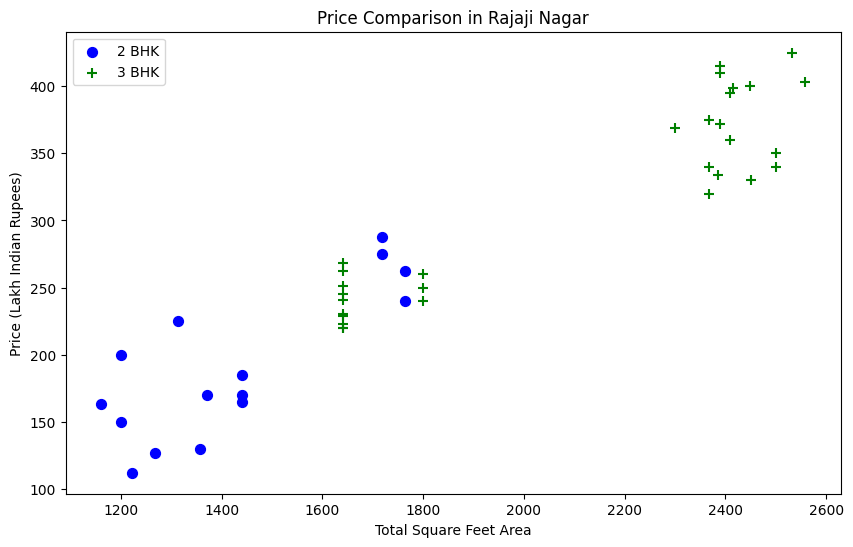

In [91]:
plot_scatter_chart(df8,"Rajaji Nagar")

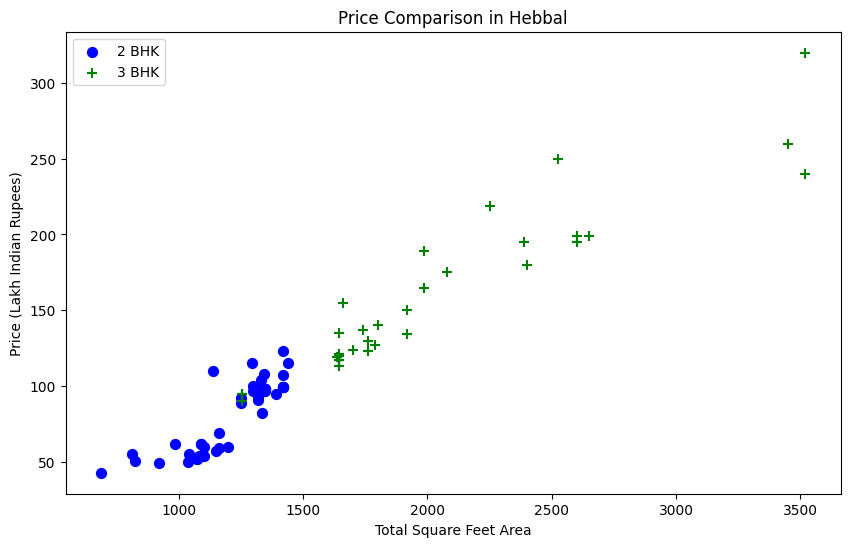

In [92]:
plot_scatter_chart(df8,"Hebbal")

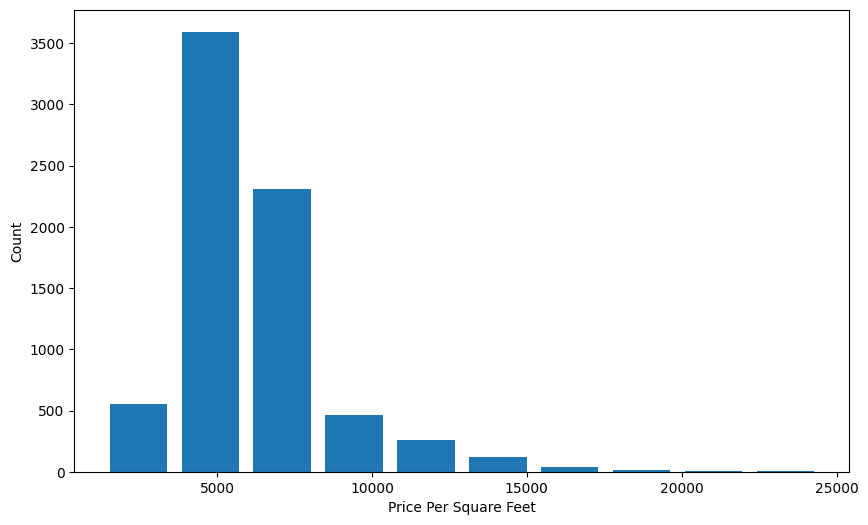

In [93]:
plt.figure(figsize=(10,6))
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.show()

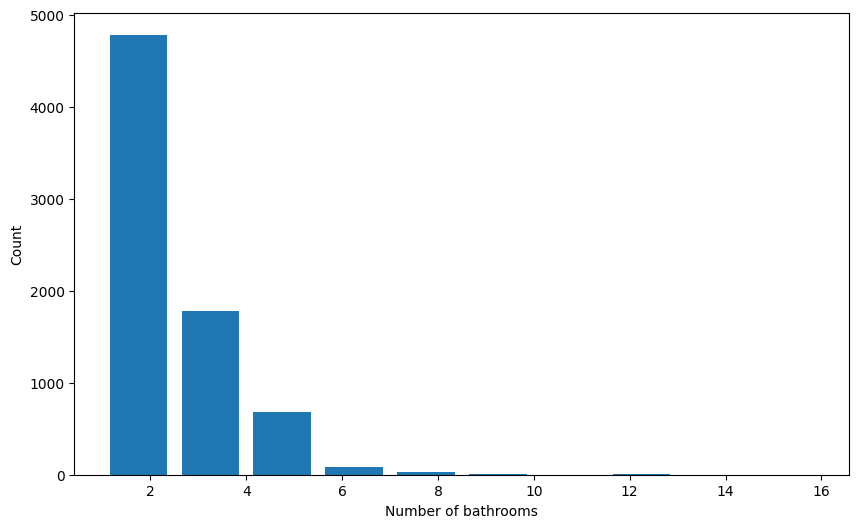

In [94]:
plt.figure(figsize=(10,6))
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")
plt.show()

In [95]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
8636,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
3096,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
3609,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
7979,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9935,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


In [96]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
7709,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
11366,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
12103,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
2620,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [97]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7286, 7)

In [98]:
df9.head(3)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
210,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
848,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2152,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333


In [99]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
210,1st Block Jayanagar,2850.0,4.0,428.0,4
848,1st Block Jayanagar,1630.0,3.0,194.0,3
2152,1st Block Jayanagar,1875.0,2.0,235.0,3


In [100]:
df10['location'].nunique()

241

In [101]:
le = LabelEncoder()
df10['location'] = le.fit_transform(df10['location'])

In [102]:
X = df10[['location', 'total_sqft', 'bath', 'bhk']]  # Shape: (7286, 4)
y = df10['price']

In [103]:
scaler = StandardScaler()
X[['total_sqft', 'bath', 'bhk']] = scaler.fit_transform(X[['total_sqft', 'bath', 'bhk']])

<ipython-input-103-0324aef432ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['total_sqft', 'bath', 'bhk']] = scaler.fit_transform(X[['total_sqft', 'bath', 'bhk']])


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model creation**

In [105]:
location_input = layers.Input(shape=(1,))
numerical_input = layers.Input(shape=(3,))

In [106]:
#Embeding for location
location_embed = layers.Embedding(241, 4)(location_input)  # 241 locations, 16D vectors
location_flat = layers.Flatten()(location_embed)

In [107]:
combined = layers.Concatenate()([location_flat, numerical_input])

In [108]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_train.shape

(5828, 4)

In [109]:
#Hidden layers
x = layers.Dense(256, activation='relu')(combined)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)

In [110]:
output = layers.Dense(1)(x)

In [111]:
#Building and compile model
model = tf.keras.models.Model(inputs=[location_input, numerical_input], outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

#Training the model
model.fit([X_train[:, 0], X_train[:, 1:]], y_train, epochs=200, batch_size=16, validation_split=0.2,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)])

# Evaluate and calculate additional metrics
y_pred = model.predict([X_test[:, 0], X_test[:, 1:]])  # Get predictions
test_loss, test_mae = model.evaluate([X_test[:, 0], X_test[:, 1:]], y_test, verbose=0)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE
test_r2 = r2_score(y_test, y_pred)  # R² score

print(f"Test MAE: {test_mae}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R² Score: {test_r2}")

Epoch 1/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8460.3936 - mae: 60.4294 - val_loss: 2200.2561 - val_mae: 21.5530
Epoch 2/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2143.0913 - mae: 23.3541 - val_loss: 1931.9181 - val_mae: 19.5259
Epoch 3/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2437.3315 - mae: 21.5408 - val_loss: 1879.5913 - val_mae: 18.9879
Epoch 4/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1484.6815 - mae: 19.9426 - val_loss: 1537.4740 - val_mae: 17.8849
Epoch 5/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1303.7698 - mae: 19.8846 - val_loss: 1909.4194 - val_mae: 22.5788
Epoch 6/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1524.6637 - mae: 20.8687 - val_loss: 1409.0817 - val_mae: 17.0024
Epoch 7/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1546.4808 - mae: 19.4968 - val_loss: 1343.0513 - val_mae: 17.3289
Epoch 8/200
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1435.8640 - mae: 19.5859 - val_loss: 1824.6042 - v

In [112]:
print(df10['price'].describe())

count    7286.000000
mean       96.755712
std        87.948657
min        10.000000
25%        50.000000
50%        72.400000
75%       110.000000
max      2200.000000
Name: price, dtype: float64
